# Experimental design (enhancing/relaxation of climatological wind field)

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import cosima_cookbook as cc
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:43943 Dashboard: /proxy/36331/status,Cluster Workers: 6 Cores: 24 Memory: 96.00 GiB


Load datasets

In [25]:
iso = xr.open_dataset('~/g_e14/misc/Antarctic_isobath_1000m.nc')

In [28]:
u = {}
v = {}
u_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.u_10.1990_1991.nc'
u['ryf'] = xr.open_dataset(u_file, decode_times = False)['uas_10m'].mean('time')
v_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.v_10.1990_1991.nc'
v['ryf'] = xr.open_dataset(v_file, decode_times = False)['vas_10m'].mean('time')
u_file_up = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_increased10.u_10.1990_1991.nc'
u['up'] = xr.open_dataset(u_file_up, decode_times = False)['uas_10m'].mean('time')
v_file_up = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_increased10.v_10.1990_1991.nc'
v['up'] = xr.open_dataset(v_file_up,decode_times = False)['vas_10m'].mean('time')
u_file_do = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_decreased10.u_10.1990_1991.nc'
u['down'] = xr.open_dataset(u_file_do, decode_times = False)['uas_10m'].mean('time')
v_file_do = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_decreased10.v_10.1990_1991.nc'
v['down'] = xr.open_dataset(v_file_do,decode_times = False)['vas_10m'].mean('time')

wind_speed = {}
for k in ['ryf', 'up', 'down']:
    wind_speed[k] = np.sqrt(u[k]**2 + v[k]**2)

In [9]:
# mask peninsula to avoid anomalies there:
peninsula_mask = wind_speed.where(wind_speed['ryf'].latitude<-68).where(wind_speed['ryf'].longitude>285).where(wind_speed['ryf'].longitude<296)*0
peninsula_mask = peninsula_mask.fillna(1)
peninsula_mask = peninsula_mask.where(peninsula_mask==1)

latitude = wind_speed['ryf'].latitude
longitude = wind_speed['ryf'].longitude

def find_min_lat(var):
    # mask outside of 60 and 80S:
    speed_mask = var.where(var.latitude<-60).where(var.latitude>-80)

    # first pass at latitude indices where speed is a minimum:
    min_lat_indices = (peninsula_mask*speed_mask).argmin(dim='latitude')

    # remove large latitude jumps in min_lat_indices:
    filtered_min_lat_indices = min_lat_indices.copy()
    for i in range(len(longitude)-1):
        if np.abs(min_lat_indices[i+1] - filtered_min_lat_indices[i]) > 4:
            filtered_min_lat_indices[i+1] = np.maximum(min_lat_indices[i+1],filtered_min_lat_indices[i])

    # and apply a smoothing:
    smoothed_min_lat_indices = np.ceil((filtered_min_lat_indices.roll(longitude=3,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=2,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=1,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=-1,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=-2,roll_coords=False) +
                                    filtered_min_lat_indices.roll(longitude=-3,roll_coords=False) + filtered_min_lat_indices)/7)

    # pick out latitude values:
    smoothed_min_lat = latitude.isel(latitude=smoothed_min_lat_indices.astype(int))
    
    return smoothed_min_lat

In [63]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

def figure_1():
    fig = plt.figure(figsize = (20, 12))
    gr = gs.GridSpec(2, 2, figure = fig, wspace = 0, hspace = 0.05); 
    axs = [fig.add_subplot(gr[:,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo())]
    for ax, lb in zip(axs, ['a)', 'b)', 'c)']):
        ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'))
        ax.spines['geo']
        ax.text(-0.03, .8, lb, transform=ax.transAxes, size = 12, weight='bold')
        ax.patch.set_alpha(0)
        ax.set_boundary(circle, transform = ax.transAxes)
    
    axs[0].text(0.65, 0.4, 'CTRL', transform = axs[0].transAxes,  bbox = dict(boxstyle = 'round', facecolor = 'white'))
    axs[1].text(0.65, 0.4, 'UP', transform = axs[1].transAxes,  bbox = dict(boxstyle = 'round', facecolor = 'white'))
    axs[2].text(0.65, 0.4, 'DOWN', transform = axs[2].transAxes,  bbox = dict(boxstyle = 'round', facecolor = 'white'))
    
    return fig, axs

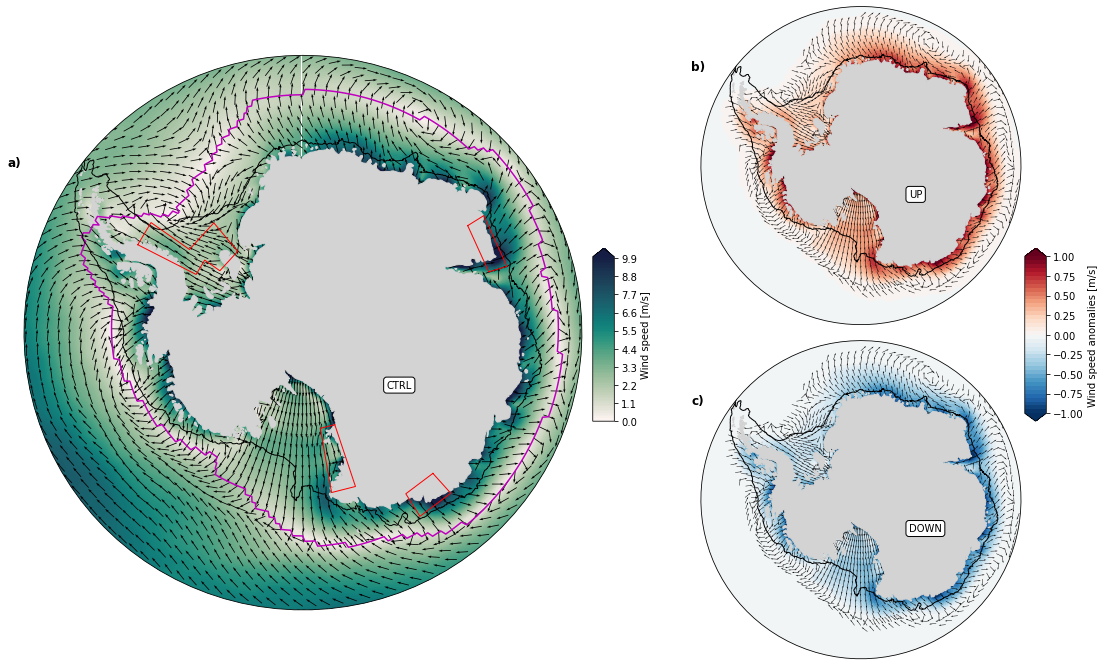

In [65]:
fig, axs = figure_1()
# Original wind field
c=axs[0].contourf(wind_speed['ryf']['longitude'], wind_speed['ryf']['latitude'], wind_speed['ryf'], 
                  cmap = cmocean.cm.tempo, levels = np.arange(0, 10.1, .1), extend = 'max', transform = ccrs.PlateCarree())
axs[0].quiver(u['ryf']['longitude'][::5], u['ryf']['latitude'][::2], 
              u['ryf'].values[::2, ::5]/wind_speed['ryf'].values[::2, ::5], 
              v['ryf'].values[::2, ::5]/wind_speed['ryf'].values[::2, ::5], 
              scale = 45, width = 1.4e-3, transform = ccrs.PlateCarree())
axs[0].plot(longitude, divide_line, color = 'm', transform = ccrs.PlateCarree())
axs[0].plot(iso['x'], iso['y'], color = 'k', linewidth = 1, transform = ccrs.PlateCarree())
# Regions masked
axs[0].plot([161.5,170,170,161.5,161.5],[-79,-79,-72,-72,-79], color = 'r', linewidth = 1, transform = ccrs.PlateCarree())
axs[0].plot([58,73,73,58,58],[-69,-69,-67,-67,-69], color = 'r', linewidth = 1, transform = ccrs.PlateCarree())
axs[0].plot([138,148,148,138,138],[-69,-69,-66.2,-66.2,-69], color = 'r', linewidth = 1, transform = ccrs.PlateCarree())
axs[0].plot([297,305,305,320,320,305,305,297,297],[-70,-70,-75,-75,-79,-79,-77,-77,-70], color = 'r', linewidth = 1, transform = ccrs.PlateCarree())
fig.colorbar(c, cax = fig.add_axes([0.52, 0.4, 0.015, 0.2]) , orientation = 'vertical').set_label('Wind speed [m/s]')
# UP perturbation
axs[1].contourf(wind_speed['up']['longitude'], wind_speed['up']['latitude'], wind_speed['up']-wind_speed['ryf'], 
                  cmap = 'RdBu_r', levels = np.arange(-1, 1.05, .05), extend = 'both', transform = ccrs.PlateCarree())
axs[1].quiver(u['up']['longitude'][::5], u['up']['latitude'][::2], 
              ((u['up']-u['ryf'])/np.sqrt((u['up']-u['ryf'])**2+(v['up']-v['ryf'])**2)).values[::2, ::5], 
              ((v['up']-v['ryf'])/np.sqrt((u['up']-u['ryf'])**2+(v['up']-v['ryf'])**2)).values[::2, ::5],
              scale = 45, width = 1.4e-3, transform = ccrs.PlateCarree())
axs[1].plot(iso['x'], iso['y'], color = 'k', linewidth = 1, transform = ccrs.PlateCarree())
# DOWN perturbation
c=axs[2].contourf(wind_speed['down']['longitude'], wind_speed['down']['latitude'], wind_speed['down']-wind_speed['ryf'], 
                  cmap = 'RdBu_r', levels = np.arange(-1, 1.05, .05), extend = 'both', transform = ccrs.PlateCarree())
axs[2].quiver(u['down']['longitude'][::5], u['down']['latitude'][::2], 
              ((u['up']-u['ryf'])/np.sqrt((u['up']-u['ryf'])**2+(v['up']-v['ryf'])**2)).values[::2, ::5], 
              ((v['up']-v['ryf'])/np.sqrt((u['up']-u['ryf'])**2+(v['up']-v['ryf'])**2)).values[::2, ::5],
              scale = 45, width = 1.4e-3, transform = ccrs.PlateCarree())
axs[2].plot(iso['x'], iso['y'], color = 'k', linewidth = 1, transform = ccrs.PlateCarree())
fig.colorbar(c, cax = fig.add_axes([0.82, 0.4, 0.015, 0.2]) , orientation = 'vertical').set_label('Wind speed anomalies [m/s]')
plt.savefig(figdir+'fig1_experimentalsetup.png', facecolor = 'white', bbox_inches = 'tight')